In [2]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import IPython.display as ipd

import soundfile as sf
import librosa
from data_utils import MudNoise
from model_stft import Mud, Mudv3, Mudv5, Mudv5noFFT
import json
import os
import torch
from torch import nn
from torch.autograd import Variable
import csv
from sep_eval import sep_eval as se
from librosa import stft
plt.style.use('classic')
from beamformers import beamformers as bf

In [3]:
datadir = '/Data/DATASETS/WSJ/mud_noise/'
validation_data_path = datadir + 'cv/debug_mud_v1.h5'

data_verbose = MudNoise(validation_data_path, noisedir='/Data/DATASETS/NoiseX/8k/', task='cv')

In [63]:
def load_mask_model(load, base_dir='.'):
    json_dir = base_dir + '/exp/' + load
    with open(json_dir + '/architecture.json', 'r') as fff:
        p = json.load(fff)
        load_path = json_dir + '/net/' + 'cv/'

        model = Mud(n_fft=p['nfft'], kernel=(p['kernel1'], p['kernel2']), causal=p['causal'],
                                layers=p['layers'], stacks=p['stacks'], verbose=False, ret_mask=True)

        mdl_idx = sorted([int(l.split('_')[-1].split('.')[0]) for l in os.listdir(load_path)])[-1]

        model.load_state_dict(torch.load(load_path + 'model_weight_{}.pt'.format(mdl_idx)))
        _ = model.eval()
        return model, p

mdl, _ = load_mask_model('201903104652_baseline2_C')

In [64]:
mix, s1 = data_verbose[200]
mix = Variable(mix[:6]).contiguous()
recon, mask, mask_noise, psd_speech, psd_noise = mdl(mix.unsqueeze(0))
# recon = mdl(mix.unsqueeze(0))

mask = mask.data.cpu().numpy()
print(mask.shape)
mask_noise = mask_noise.data.cpu().numpy()
print(mask_noise.shape)

psd_speech = psd_speech.data.cpu().numpy()
print(psd_speech.shape)
psd_noise = psd_noise.data.cpu().numpy()
print(psd_noise.shape)

m = mix.data.cpu().numpy()
s = s1.data.cpu().numpy()
r = recon.squeeze().data.cpu().numpy()
ipd.display(ipd.Audio(m, rate=8000))
ipd.display(ipd.Audio(r, rate=8000))

print(se.sdr(s[0], m[0]))
print(se.sdr(r, s[0]))

(1, 257, 1, 1, 257)
(1, 257, 1, 1, 257)
(1, 257, 2, 6, 6)
(1, 257, 2, 6, 6)


AttributeError: module 'sep_eval' has no attribute 'sdr'

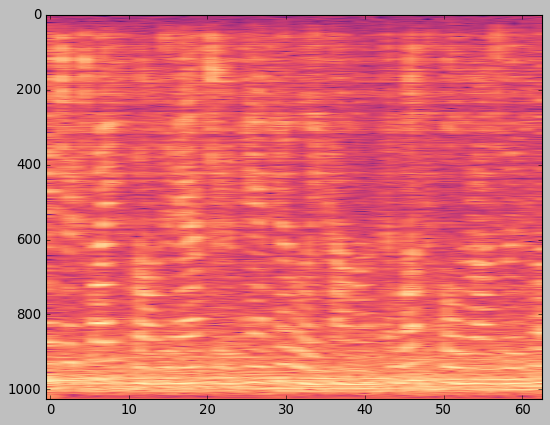

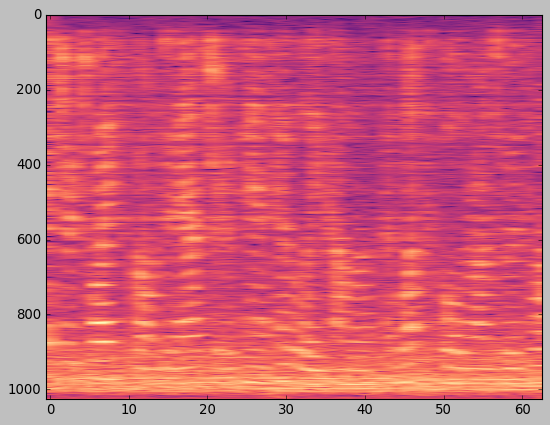

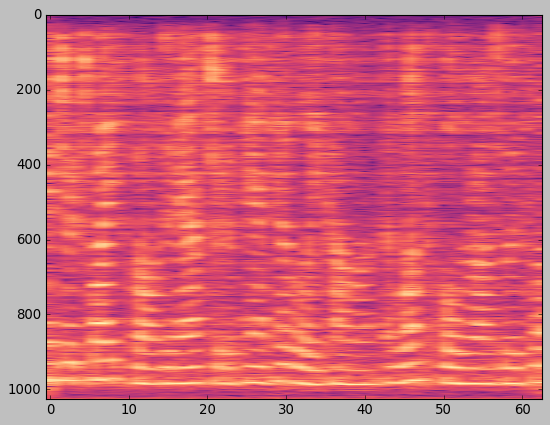

In [70]:
for i in range(2):
    X = np.log10(np.abs(librosa.stft(m[i])) + 1e-15)[::-1]
    plt.figure()
    plt.imshow(X, aspect='auto', cmap='magma')
    plt.savefig('ex_mix_ch{}.pdf'.format(i))

plt.figure()
X = np.log10(np.abs(librosa.stft(r)) + 1e-15)[::-1]
plt.imshow(X, aspect='auto', cmap='magma')
plt.savefig('ex_sep.pdf'.format(i))

# plt.figure()
# X = mask.squeeze()[::-1]
# plt.imshow(X, aspect='auto', cmap='magma')
# plt.savefig('ex_mask.pdf')

# plt.figure()
# X = mask_noise.squeeze()[::-1]
# plt.imshow(X, aspect='auto', cmap='magma')
# plt.savefig('ex_mask_noise.pdf')

# plt.figure()
# X = psd_noise.squeeze()[50, 0]
# plt.imshow(X, aspect='auto', cmap='magma')
# plt.savefig('ex_psd_noise.pdf')

# plt.figure()
# X = psd_speech.squeeze()[200, 0]
# plt.imshow(X, aspect='auto', cmap='magma')
# plt.savefig('ex_psd_speech.pdf')

In [ ]:
print(recon)

In [4]:
# (all files)
all_files_names = []
all_traces = []
all_mics = []
all_nspk = {}
with open("/Data/Dropbox/cocoha_workshop_zh/cocoha_code/automated_exps/output_session2_15s.csv", "r") as f:
    reader = csv.reader(f, delimiter=",")
    
    for i, line in enumerate(reader):
        all_nspk[line[0]] = int(line[-1])
        all_traces.append(line[5:-1])
        all_mics.append(line[1:5])
        all_files_names.append(line[0])

print(len(all_files_names))

158


In [ ]:
def find_trigger_v2(x):
    Y = x
    X = stft(Y)
    Y = np.log10(np.abs(X) ** 2 + 1e-8)
    YY = np.sum(Y, 0)
    n90 = np.percentile(YY, 65)
    tr = np.where(YY >= n90)[0][0]
    return tr * 512

def allign(x, y):
    corr = np.correlate(x - np.mean(x), y - np.mean(y), mode='full')
    lag = corr.argmax() - (len(x) - 1)
    _err_log = "OK"

    if lag > 0:
        x = x[lag:]
        y = y[:-lag]
    else:
        x = x[:]
        y = y[:]
        _err_log = "ERROR: lag {}".format(lag)
    return x, y, _err_log


In [ ]:
name = '20190222101808'
all_data = []
t_in_secs = []
fs = 8000
for i in [5, 6, 7, 8]:
#     _fs, _y = wavfile.read('../data_whisper/session2/test_%s_wh%d.wav' % (name, i))
    _y, _fs = librosa.load('/Data/Dropbox/cocoha_workshop_zh/cocoha_code/data_whisper/session2/test_%s_wh%d.wav' % (name, i), sr=8000, mono=False)
    _y = _y.T.astype('float32')
    all_data.append(_y)
    assert(_fs == fs)
    t_in_secs.append(_y.shape[0] // fs)
    print("%d: %d seconds" % (i, _y.shape[0] // fs), end='\t\t')

# n_spk = all_nspk[name]
n_spk = 1
# print("N SPK: {}".format(n_spk))
m_len = np.min([a.shape[0] for a in all_data])
all_data_cut = [a[:m_len] for a in all_data]
all_data_array = np.hstack(all_data_cut) #.astype('float32')


t = np.arange(len(all_data_array[:, 0])) / fs

for_trigger = all_data_array[:, 6]
trigger = find_trigger_v2(for_trigger)
noise_calib = all_data_array[:trigger]
# noise_calib = NOISE_CALIB
print("Noise {}    [MAX = 22s]".format(len(noise_calib) // fs))
calib1 = all_data_array[0 * fs + trigger: 10 * fs + trigger]
calib2 = all_data_array[15 * fs + trigger: 25 * fs + trigger]
calib3 = all_data_array[30 * fs + trigger: 40 * fs + trigger]
calib4 = all_data_array[45 * fs + trigger: 55 * fs + trigger]

rec = all_data_array[max((15 * n_spk), 30) * fs + trigger:]

print("Removing trigger => [{} ~= {}]".format(t_in_secs[0] - trigger // fs, max((15 * n_spk), 30) + 15))

plt.plot(for_trigger[:trigger + 5 * fs])
plt.plot([trigger, trigger], [np.min(for_trigger[:trigger + 5 * fs]), np.max(for_trigger[:trigger + 5 * fs])], 'g--')

In [ ]:
IDX = '20190222110009'
n_ch = 8
fs = 8000
frame_len = 512
frame_step = 128
keys = list(data.keys())
max_len = 32000
rec = data[IDX]['rec']
calib_speech = data[IDX]['calib_voice']
calib_noise = data[IDX]['calib_noise']
print(data[IDX]['SNR'])

train_rec = rec.T[:n_ch, :max_len]
train_cs = calib_speech.T[:n_ch, :max_len]
train_cn = calib_noise.T[:n_ch, :max_len]

test_rec = rec.T[:n_ch, max_len:]
test_cs = calib_speech.T[:n_ch, max_len:]
test_cn = calib_noise.T[:n_ch, max_len:]

observation = bf.stft(train_rec, frame_len=frame_len, frame_step=frame_step)
mixture_stft = bf.stft(test_rec, frame_len=frame_len, frame_step=frame_step)

re_o = np.real(observation[0])
im_o = np.imag(observation[0])

re_m = re_o.astype('float32')[None, ...]
im_m = im_o.astype('float32')[None, ...]

mix = np.vstack([re_m, im_m])[None, ...]  # (B, 2, F L)

mix = Variable(torch.from_numpy(mix)).contiguous()

mask = mdl(mix).squeeze().data.cpu().numpy()

mask_speech = mask.astype('complex64')
mask_noise = 1 - mask_speech + 1e-15

w = bf.mb_mvdr_weights(observation, mask_noise, mask_speech)

sep_spec = bf.apply_beamforming_weights(mixture_stft, w)
reconstructed = bf.istft(sep_spec, frame_len=frame_len, frame_step=frame_step, input_len=len(test_rec[0]))

sep_spec_train = bf.apply_beamforming_weights(observation, w)
reconstructed_train = bf.istft(sep_spec_train, frame_len=frame_len, frame_step=frame_step, input_len=len(test_rec[0]))


ipd.display(ipd.Audio(reconstructed, rate=8000))
ipd.display(ipd.Audio(reconstructed_train, rate=8000))

In [ ]:
IDX = '20190222110009'
n_ch = 8
fs = 8000
keys = list(data.keys())
rec = data[IDX]['rec']
calib_speech = data[IDX]['calib_voice']
calib_noise = data[IDX]['calib_noise']
print(data[IDX]['SNR'])
mix = Variable(torch.from_numpy(rec.T[:n_ch])).contiguous()
print(mix.shape)
y_net = mdl(mix.unsqueeze(0)).squeeze().data.cpu().numpy()[:10 * fs]
y_beam = bf.MB_MVDR(rec.T[:n_ch], noise=calib_noise.T[:n_ch], target=calib_speech.T[:n_ch], mask='IRM')[:10 * fs]
y_beam_2 = bf.SDW_MWF(rec.T[:n_ch], noise=calib_noise.T[:n_ch], target=calib_speech.T[:n_ch])[:10 * fs]

y = calib_speech[:, 0]
noisy = rec[:10 * fs, 0]

# calculate best correlation lag
y_net, y_2, _ = allign(y_net, y)
y_noisy, y_3, _ = allign(noisy, y)
y_beam, y_4, _ = allign(y_beam, y)
y_beam_2, y_5, _ = allign(y_beam_2, y)

# SDR
print("NET   : {:.4}".format(se.sdr(y_net, y_2)))
print("MB: {:.4}".format(se.sdr(y_beam, y_4)))
print("SDW: {:.4}".format(se.sdr(y_beam_2, y_5)))
print("NOISY : {:.4}".format(se.sdr(y_noisy, y_3)))

In [ ]:
ipd.display(ipd.Audio(y_net, rate=8000))

In [ ]:
ipd.display(ipd.Audio(y_net, rate=8000))

In [ ]:
mdl1, _ = load_mask_model('201903152913_Mudv4_C_512_6')
print(sum(p.numel() for p in mdl1.parameters() if p.requires_grad))
mdl2, _ = load_mask_model('201903152912_Mudv4_C_512_4')
print(sum(p.numel() for p in mdl2.parameters() if p.requires_grad))
mdl3, _ = load_mask_model('201903152912_Mudv4_NC_512_6')
print(sum(p.numel() for p in mdl3.parameters() if p.requires_grad))
mdl4, _ = load_mask_model('201903152912_Mudv4_NC_512_4')
print(sum(p.numel() for p in mdl4.parameters() if p.requires_grad))

In [ ]:
mdl1, _ = load_mask_model('201903152913_Mudv4_C_512_6')
mdl2, _ = load_mask_model('201903152912_Mudv4_C_512_4')
mdl3, _ = load_mask_model('201903152912_Mudv4_NC_512_6')
mdl4, _ = load_mask_model('201903152912_Mudv4_NC_512_4')

models = [mdl1, mdl2, mdl3, mdl4, bf.MB_MVDR, bf.SDW_MWF]
desc = ['C_512_6', 'C_512_4', 'NC_512_6', 'NC_512_4', 'MB_MVDR', 'SDW_MWF']
m_type = ['n', 'n', 'n', 'n', 'm', 'b']

keys = list(data.keys())

with open('results_real_data_v1.csv', 'w') as csv_file:
    file_writer = csv.writer(csv_file, delimiter=',')
    
    header = ['model', 'snr', 'n_ch', 'sdr', 'stoi']
    file_writer.writerow(header)
    
    for IDX in range(60):
        print("Sample: {}".format(IDX))
        rec = data[keys[IDX]]['rec'].T
        calib_speech = data[keys[IDX]]['calib_voice'].T
        calib_noise = data[keys[IDX]]['calib_noise'].T
        snr = data[keys[IDX]]['SNR']
        mix = Variable(torch.from_numpy(rec)).contiguous()
        
        for n_ch in [2, 4, 8, 12]:
            print("\tCH: {}".format(n_ch))
            for model, tp, i in zip(models, m_type, desc):
                print("\t\tModel: {} ({})".format(i, tp))
                if tp == 'n':
                    y_hat = model(mix.unsqueeze(0)[:, :n_ch]).squeeze().data.cpu().numpy()[:10 * fs]
                elif tp == 'm':
                    y_hat = model(rec[:n_ch], noise=calib_noise[:n_ch], target=calib_speech[:n_ch], mask='IRM')[:10 * fs]
                else:
                    y_hat = model(rec[:n_ch], noise=calib_noise[:n_ch], target=calib_speech[:n_ch])[:10 * fs]

                y = calib_speech[0]

                # calculate best correlation lag
                y_hat, y_2, error = allign(y_hat, y)
                print("\t\t\tAllign: {}".format(error))

                # SDR
                sdr = se.sdr(y_hat, y_2)
                stoi = se.stoi(y_hat, y_2, fs=8000)

                file_writer.writerow([i, snr, n_ch, sdr, stoi])

# Try to load the full WHISPER dataset (ENH)

In [ ]:
def find_trigger_v2(x):
    Y = x
    X = stft(Y)
    Y = np.log10(np.abs(X) ** 2 + 1e-8)
    YY = np.sum(Y, 0)
    n90 = np.percentile(YY, 65)
    tr = np.where(YY >= n90)[0][0]
    return tr * 512

In [ ]:
timestamps = []
speakers = []
valids = []
all_nspk = {}
all_snr = []


with open("/Data/Dropbox/cocoha_workshop_zh/cocoha_code/automated_exps/output_session2_15s.csv", "r") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        all_nspk[line[0]] = int(line[-1])
        timestamps.append(line[0])
        speakers.append(np.array(line[1:5]))
        _traces = line[5:-1]
        valids.append(np.array(np.where(np.array(_traces) != '/Users/enea/DATASETS/Noise/silence.wav')[0]))
print(len(timestamps))

In [ ]:
all_samples = {}
fs = 24000
for name in timestamps:
    sample = {}
    print(name)
    all_data = []
    t_in_secs = []
    for i in [5, 6, 7, 8]:
        _y, _fs = sf.read('/Data/Dropbox/cocoha_workshop_zh/cocoha_code/data_whisper/session2/test_%s_wh%d.wav' % (name, i))
        _y = _y.astype('float32')
        all_data.append(_y)
        assert(_fs == fs)
        t_in_secs.append(_y.shape[0] // fs)
        print("%d: %d seconds" % (i, _y.shape[0] // fs), end='\t\t')

    n_spk = all_nspk[name]
    m_len = np.min([a.shape[0] for a in all_data])
    all_data_cut = [a[:m_len] for a in all_data]
    all_data_array = np.hstack(all_data_cut) #.astype('float32')


    t = np.arange(len(all_data_array[:, 0])) / fs

    for_trigger = all_data_array[:, 6]
    trigger = find_trigger_v2(for_trigger)
    noise_calib = all_data_array[:trigger]
    # noise_calib = NOISE_CALIB
    print("\tNoise {}    [MAX = 22s]".format(len(noise_calib) // fs))
#     calib1 = all_data_array[0 * fs + trigger: 10 * fs + trigger]
#     calib2 = all_data_array[15 * fs + trigger: 25 * fs + trigger]
#     calib3 = all_data_array[30 * fs + trigger: 40 * fs + trigger]
#     calib4 = all_data_array[45 * fs + trigger: 55 * fs + trigger]
    calib = [all_data_array[i * 15 * fs + trigger: ((i*15) + 10) * fs + trigger] for i in range(max(2, n_spk))]

    rec = all_data_array[max((15 * n_spk), 30) * fs + trigger:]
    
    if any([c.shape[0] != 10 * fs for c in calib]) or rec.shape[0] < 10 * fs:
        print('\t!!!Check trigger!!!')
        print(calib[0].shape)
        print(calib[1].shape)
        continue
    
    sample['rec'] = rec
    for j, c in enumerate(calib): 
        sample['calib{}'.format(j)] = c
    
    all_samples[name] = sample
    
    print("\tRemoving trigger => [{} ~= {}]".format(t_in_secs[0] - trigger // fs, max((15 * n_spk), 30) + 15))

#     plt.plot(for_trigger[:trigger + 5 * fs])
#     plt.plot([trigger, trigger], [np.min(for_trigger[:trigger + 5 * fs]), np.max(for_trigger[:trigger + 5 * fs])], 'g--')

In [ ]:
pkl.dump(all_samples, open('session_2_full.pkl', 'wb'))

In [ ]:
mdl.cuda()
s = all_samples[0]

mix = Variable(torch.from_numpy(s['rec'].T[:8])).contiguous().cuda()
recon = mdl(mix.unsqueeze(0))

ipd.display(ipd.Audio(s['calib_voice'][:, 0], rate=8000))
ipd.display(ipd.Audio(s['rec'][:, 0], rate=8000))
ipd.display(ipd.Audio(recon.squeeze().data.cpu().numpy(), rate=8000))

In [ ]:
import pickle as pkl

data = pkl.load(open('session_2_enh.pkl', 'rb'))
print(len(data))
print(data.keys())

In [ ]:
print(np.min(data['20190222111346']['rec']))
print(np.max(data['20190222111346']['rec']))

In [ ]:


K = MudNoise('/Data/DATASETS/WSJ/mud_noise/cv/debug_mud_v1.h5', noisedir='/Data/DATASETS/NoiseX/8k/', task='cv', n_ch=6, verbose=True)

A, B, C = [], [], []
for i in range(200):
    a, b, c = K[i]
    A.append(a.unsqueeze(0))
    B.append(b.unsqueeze(0))
    C.append(c)

_mix = torch.cat(A, 0)
_s1 = torch.cat(B, 0)
_n = np.array(C)

rec = _mix.data.numpy()
calib_speech = _s1.data.numpy()
calib_noise = _n

print(rec.shape)
print(calib_speech.shape)
print(calib_noise.shape)

In [ ]:
import pickle as pkl
d = pkl.load(open('debug.pkl', 'rb'))


In [ ]:
idx = 20
# c_speech = calib_speech[idx]
# c_noise = calib_noise[idx]
# r = rec[idx]
c_speech = d['y']
c_noise = d['n']
r = d['r']

y_beam = bf.MB_MVDR(r, noise=c_noise, target=c_speech, mask='IBM')
y_beam_2 = bf.SDW_MWF(r, noise=c_noise, target=c_speech)

y = c_speech[0]

# calculate best correlation lag
y_beam, y_4, _ = allign(y_beam, y)
y_beam_2, y_5, _ = allign(y_beam_2, y)

# SDR
print("MB: {:.4}".format(se.sdr(y_beam, y_4)))
print("SDW: {:.4}".format(se.sdr(y_beam_2, y_5)))

In [1]:
import pickle as pkl

data = pkl.load(open('session_2_full.pkl', 'rb'))
print(len(data))
print(data.keys())
print(data['20190222080236'].keys())

144
dict_keys(['20190222080236', '20190222080344', '20190222080453', '20190222080601', '20190222080818', '20190222081035', '20190222081143', '20190222081251', '20190222081507', '20190222081615', '20190222081723', '20190222081832', '20190222081940', '20190222082048', '20190222082156', '20190222082304', '20190222082412', '20190222082520', '20190222082629', '20190222082737', '20190222082845', '20190222082953', '20190222083101', '20190222083209', '20190222083317', '20190222083425', '20190222083534', '20190222083642', '20190222083805', '20190222083929', '20190222084052', '20190222084216', '20190222084339', '20190222084503', '20190222084626', '20190222084750', '20190222084913', '20190222085037', '20190222085201', '20190222085324', '20190222085448', '20190222085735', '20190222085858', '20190222090022', '20190222090309', '20190222090556', '20190222090719', '20190222090843', '20190222091006', '20190222091130', '20190222091253', '20190222091417', '20190222091704', '20190222091827', '201902220921

In [5]:
print(all_nspk)

{'20190222080236': 2, '20190222080344': 2, '20190222080453': 2, '20190222080601': 2, '20190222080818': 2, '20190222080926': 2, '20190222081035': 2, '20190222081143': 2, '20190222081251': 2, '20190222081359': 2, '20190222081507': 2, '20190222081615': 2, '20190222081723': 2, '20190222081832': 2, '20190222081940': 2, '20190222082048': 2, '20190222082156': 2, '20190222082304': 2, '20190222082412': 2, '20190222082520': 2, '20190222082629': 2, '20190222082737': 2, '20190222082845': 2, '20190222082953': 2, '20190222083101': 2, '20190222083209': 2, '20190222083317': 2, '20190222083425': 2, '20190222083534': 2, '20190222083642': 3, '20190222083805': 3, '20190222083929': 3, '20190222084052': 3, '20190222084216': 3, '20190222084339': 3, '20190222084503': 3, '20190222084626': 3, '20190222084750': 3, '20190222084913': 3, '20190222085037': 3, '20190222085201': 3, '20190222085324': 3, '20190222085448': 3, '20190222085735': 3, '20190222085858': 3, '20190222090022': 3, '20190222090145': 3, '20190222090

In [8]:
import os
datadir = '/Data/DATASETS/WHISPER_SET_1/data_filtered/'

for key, value in data.items():
    n_spk = max(all_nspk[key], 2)
    os.mkdir(datadir + 'sample_{}'.format(key))
    for i in range(n_spk):
        sf.write(datadir + 'sample_{}/'.format(key) + 'calib{}.wav'.format(i), value['calib{}'.format(i)], 24000)
    sf.write(datadir + 'sample_{}/'.format(key) + 'mixture.wav'.format(i), value['rec'], 24000)

In [ ]:
y, fs = sf.read('/Data/DATASETS/WHISPER_SET_1/data_filtered/sample_20190222080236/calib1.wav')
ipd.display(ipd.Audio(y[:, 0], rate=fs))